# CIFAR 10 Classifier


In [1]:
# 필수 모듈 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# EPOCH, BATCH_SIZE 결정
EPOCH = 40
batch_size = 16

# 이미지 변형 및 전처리
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10,scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터셋 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR10 클래스 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 이미지 출력 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# 네트워크 정의
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.pool = nn.MaxPool2d(2, 2, 1)

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)

        self.dropout1 = nn.Dropout(0.5, inplace=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

net = Net()

# 손실함수, 최적화함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train

In [ ]:
# 학습 시작
for epoch in range(EPOCH):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[EPOCH: {epoch + 1}] | loss: {running_loss / 2000:.3f}')

            running_loss = 0.0

print('Finished Training')

In [ ]:
# 모델 저장
PATH = "./cifar10.pth"
torch.save(net.state_dict(), PATH)

### Evaluation

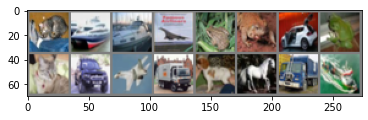

Answer:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [3]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Answer: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
PATH = "./cifar10.pth"
net = Net()
net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
outputs = net(images)

In [7]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

Predicted:  cat   ship  ship  plane deer  frog  car   frog  dog   car   dog   truck dog   horse truck ship 


In [8]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [9]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 8.9 %
Accuracy for class: car   is 6.8 %
Accuracy for class: bird  is 1.5 %
Accuracy for class: cat   is 13.0 %
Accuracy for class: deer  is 2.7 %
Accuracy for class: dog   is 13.4 %
Accuracy for class: frog  is 17.7 %
Accuracy for class: horse is 5.5 %
Accuracy for class: ship  is 17.7 %
Accuracy for class: truck is 14.3 %
